In [1]:
import matplotlib.pyplot as plt

from eryn.utils import TransformContainer

from lisatools.diagnostic import *
from lisatools.utils.constants import *

### Inner Product

Make a simple waveform model

In [2]:
def sine_waveform(A, f, phi0, t_arr):
    return A * np.sin(2 * np.pi * f * t_arr + phi0)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:863: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:865: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:867: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:872: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:874: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d *

Inner product <h1|h2>: 111.08176904161803
Complex inner product <h1|h2>: (111.08176904161805+22.517610949389915j), phase maximized value: 113.3410879437967
Normalized inner product <h1|h2>: 0.9800657317006768


(1e-05, 0.10206431774793984)

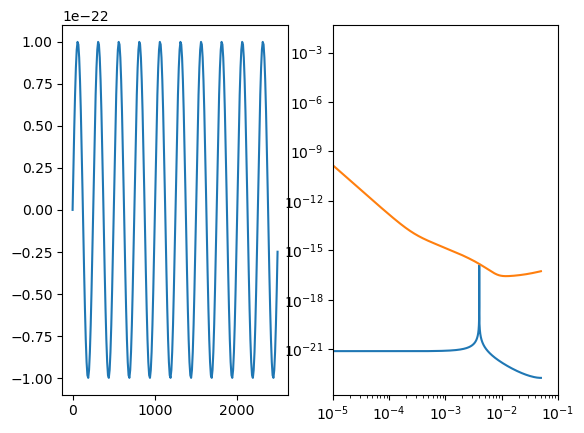

In [3]:
# create some fake signals first

A = 1e-22
f = 4e-3
phi0 = 0.2

dt = 10.0
t_arr = np.arange(0.0, YRSID_SI, dt)
df = 1 / (len(t_arr) * dt)
h1 = sine_waveform(A, f, 0.0, t_arr)
h2 = sine_waveform(A, f, phi0, t_arr)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(t_arr[:250], h1[:250])

freqs = np.fft.rfftfreq(len(h1), dt)
ax2.loglog(freqs, np.abs(np.fft.rfft(h1)))

ax2.loglog(freqs, (get_sensitivity(freqs, sens_fn="lisasens", model="sangria", includewd=1) / (4 * df)) ** (1/2))

val = inner_product(h1, h2, dt=dt, PSD="lisasens", PSD_kwargs=dict(model="sangria", includewd=1))
print(f"Inner product <h1|h2>: {val}")

complex_val = inner_product(h1, h2, dt=dt, PSD="lisasens", PSD_kwargs=dict(model="sangria", includewd=1), complex=True)
print(f"Complex inner product <h1|h2>: {complex_val}, phase maximized value: {np.abs(complex_val)}")

normalized_val = inner_product(h1, h2, dt=dt, PSD="lisasens", PSD_kwargs=dict(model="sangria", includewd=1), normalize=True)
print(f"Normalized inner product <h1|h2>: {normalized_val}")

ax2.set_xlim(1e-5,)

### SNR

In [4]:
opt_snr = snr(h1, dt=dt, PSD="lisasens", PSD_kwargs=dict(model="sangria", includewd=1))
print(f"Optimal SNR <h1|h1>^(1/2): {opt_snr}")

det_snr = snr(h1, data=h2, dt=dt, PSD="lisasens", PSD_kwargs=dict(model="sangria", includewd=1))
print(f"Detected SNR against data h1 <h1|h2> / <h1|h1>^(1/2): {det_snr}")

Optimal SNR <h1|h1>^(1/2): 10.646164923358164
Detected SNR against data h1 <h1|h2> / <h1|h1>^(1/2): 10.433970339675994


### Perturbed Waveform

In [5]:
# set quantities for below calculations
params = np.array([np.log(A), f * 1e3, phi0])
eps = 1e-9
index = 1

parameter_transforms = {
    0: np.exp,
    1: lambda x: x / 1e3
}

transform_fn = TransformContainer(parameter_transforms=parameter_transforms)


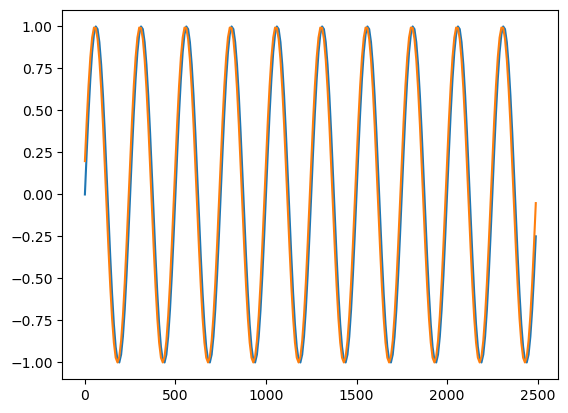

In [6]:
params = np.array([np.log(A), f * 1e3, phi0])
step = 1e-9
index = 1

parameter_transforms = {
    0: np.exp,
    1: lambda x: x / 1e3
}

transform_fn = TransformContainer(parameter_transforms=parameter_transforms)

# will return 2D
dh = h_var_p_eps(
    step,
    sine_waveform,
    params,
    index,
    waveform_args=(t_arr,),
    parameter_transforms=transform_fn
)

# TODO: check this?
plt.plot(t_arr[:250], h1[:250] / np.abs(h1[:250]).max())
plt.plot(t_arr[:250], dh[0, :250] / np.abs(dh[0, :250]).max())

### Derivative of Waveform

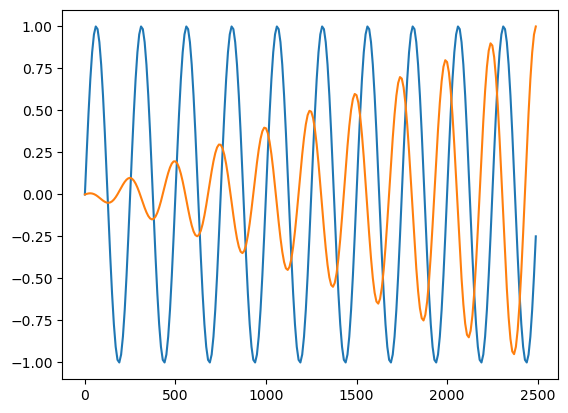

In [7]:
dhdlam = dh_dlambda(
    eps,
    sine_waveform,
    params,
    index,
    waveform_args=(t_arr,),
    parameter_transforms=transform_fn
)

# TODO: check this?
plt.plot(t_arr[:250], h1[:250] / np.abs(h1[:250]).max())
plt.plot(t_arr[:250], dhdlam[0, :250] / np.abs(dhdlam[0, :250]).max())

### Information Matrix and Covariance

In [8]:
params = np.array([np.log(A), f * 1e3, phi0])
eps = 1e-9

info_mat_args = (eps, sine_waveform, params)
info_mat_kwargs = dict(
    deriv_inds=None,
    inner_product_kwargs={
        "PSD": "lisasens",
        "PSD_kwargs": dict(model="sangria", includewd=1.0),
        "dt": dt,
    },
    return_derivs=False,
    waveform_args=(t_arr,),
    parameter_transforms=transform_fn,
)
im = info_matrix(*info_mat_args, **info_mat_kwargs)

cov = covariance(
    *info_mat_args,
    info_mat=None,
    diagonalize=False,
    return_info_mat=False,
    precision=True,
    **info_mat_kwargs,
)
print(cov)

[[ 8.82297833e-03 -9.69464622e-13 -6.28575990e-08]
 [-9.69464622e-13  2.60701672e-12 -2.59713615e-07]
 [-6.28575990e-08 -2.59713615e-07  3.48797775e-02]]


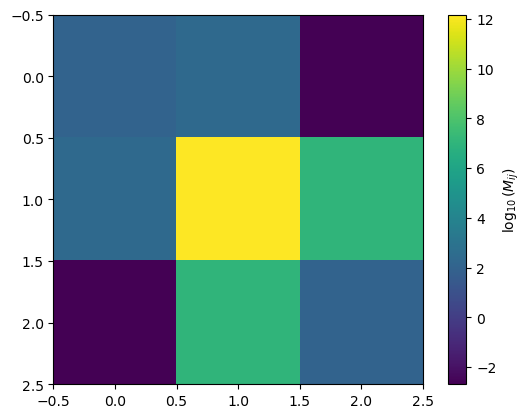

In [9]:
plt.imshow(np.log10(im))
plt.colorbar(label=r"$\log_{10}(M_{ij})$")

### Plot the covariance matrix in a corner plot

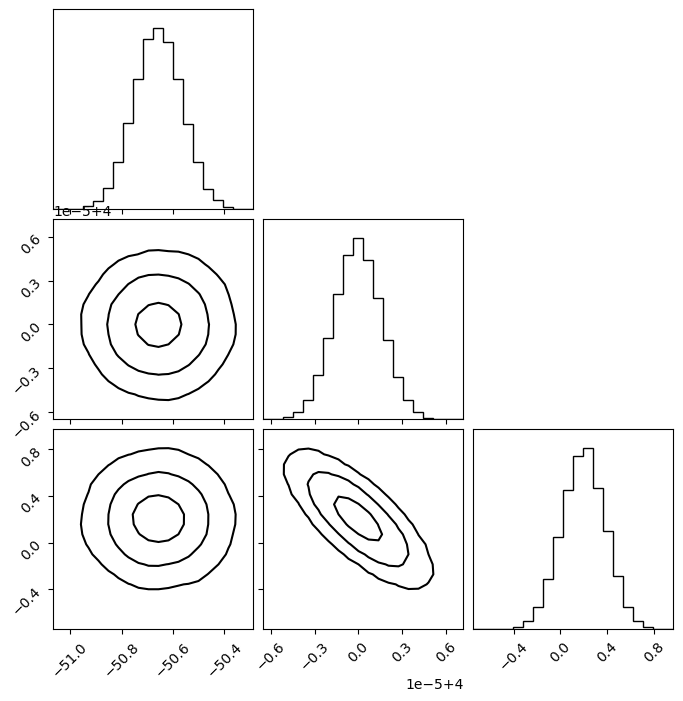

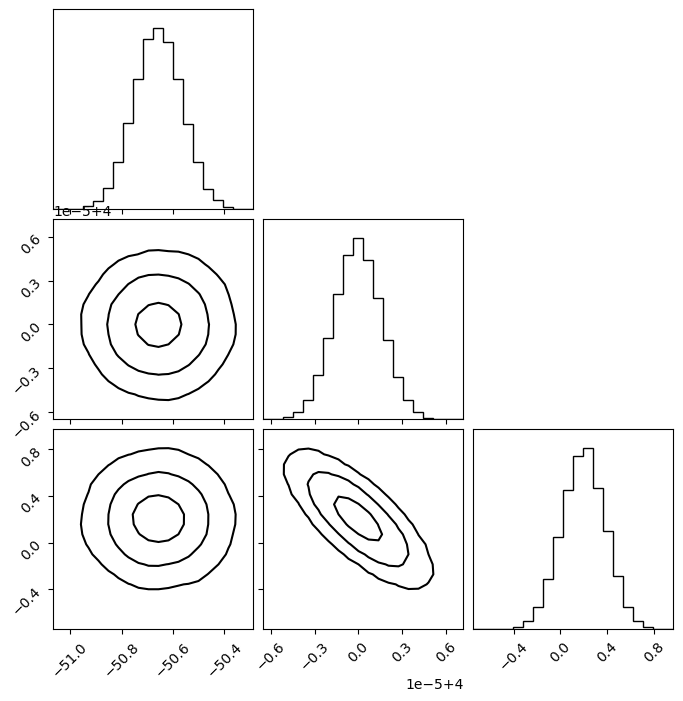

In [10]:
plot_kwargs = dict(
    plot_density=False,
    plot_datapoints=False,  # fake in this case
    smooth=0.8,
    levels=1 - np.exp(-0.5 * np.array([1, 2, 3]) ** 2)  # 1, 2, 3 sigma
)

plot_covariance_corner(
    params,
    cov,
    **plot_kwargs
)

Make a single contour plot.

<Axes: >

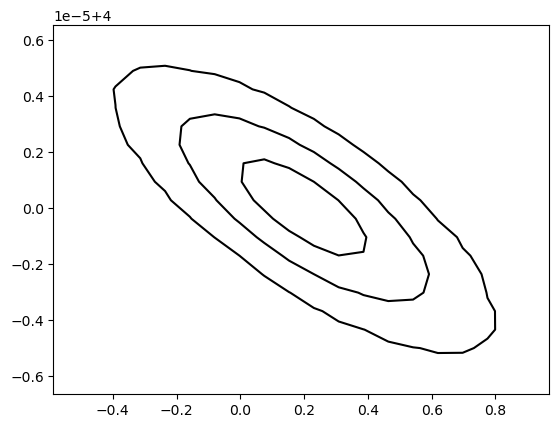

In [11]:
fig, ax = plt.subplots(1,1)

plot_covariance_contour(
    params,
    cov,
    2,
    1,
    ax=ax,
    **plot_kwargs
)

### Get Eigeninfo of a matrix (high-precision capability)

In [12]:
evals, evecs = get_eigeninfo(
    cov, high_precision=False
)
evals, evecs

(array([8.82297833e-03, 3.48797775e-02, 6.73198137e-13]),
 array([[ 1.00000000e+00,  2.41233002e-06, -1.62926857e-10],
        [-1.80888983e-10,  7.44596537e-06, -1.00000000e+00],
        [ 2.41233002e-06, -1.00000000e+00, -7.44596537e-06]]))

### Scale a signal to a given SNR

In [13]:
target_snr = 30.0
h1 = sine_waveform(A, f, 0.0, t_arr)

h1_scaled = scale_to_snr(
    target_snr,
    h1,
    dt=dt, 
    PSD="lisasens", 
    PSD_kwargs=dict(model="sangria", includewd=1)
)

print(h1 / h1_scaled)

/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:863: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:865: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:867: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:872: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:874: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d *

[       nan 0.35487216 0.35487216 ... 0.35487216 0.35487216 0.35487216]


/Users/mlkatz1/miniconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:628: RuntimeWarning: divide by zero encountered in power
  * (fr ** (-7.0 / 3.0))
/var/folders/j0/bh276m5s531565_7zdy_t5m40000gp/T/ipykernel_9457/1909549491.py:12: RuntimeWarning: invalid value encountered in divide
  print(h1 / h1_scaled)


### Bias estimate

Approximate waveform with a purposeful bias on the amplitude

In [14]:
def sine_waveform_approx(A, f, phi0, t_arr):
    return A * 1.03 * np.sin(2 * np.pi * (f * 0.98) * t_arr + phi0)


In [16]:
sys_err, bias = cutler_vallisneri_bias(
    sine_waveform,
    sine_waveform_approx,
    params,
    eps,
    parameter_transforms=transform_fn,
    inner_product_kwargs={
        "PSD": "lisasens",
        "PSD_kwargs": dict(model="sangria", includewd=1.0),
        "dt": dt,
    },
    waveform_true_args=(t_arr,),
)
print(sys_err, bias)

[1.13345945e+02 9.08124948e+02 1.15347922e-02] [ 1.00004882e+00 -7.38130550e-10  1.59353919e-04]
